In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models #add models to list
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
#define transforms
train_transform = transforms.Compose([
 
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.255])
    
])

In [7]:
#we just use the test data to validate the capability of the network, so we dont need rotation & flip 
test_transform = transforms.Compose([
    
    transforms.Resize(224), #resize to ensure it's the same dimension as network
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.255]) #to ensure the model has same value range as what network has been trained
    
])

In [8]:
root = 'C:/Users/A221LPEN/Desktop/Pytorch_for_Deep_Learning/PYTORCH_NOTEBOOKS/myCodes/Data/CATS_DOGS/'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)

test_data = datasets.ImageFolder(os.path.join(root,'test'),transform=test_transform)

torch.manual_seed(42)

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data,batch_size=10)

class_names = train_data.classes



In [9]:
class_names

['CAT', 'DOG']

In [10]:
len(train_data)

18743

In [11]:
len(test_data)

6251

In [13]:
#grab 1st batch images from the train data
for images, labels in train_loader:
    break
    

In [14]:
images.shape # 10-images, 3-rgb/colour image channel, 224--due to resizing

torch.Size([10, 3, 224, 224])

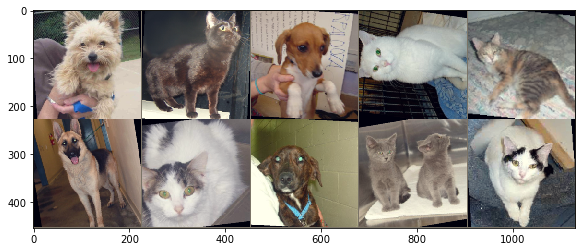

In [15]:
im = make_grid(images,nrow=5)

inv_normalize = transforms.Normalize(
    #grab mean & divide by std and take the reciprocal of std
    mean = [-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std = [1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1,2,0))); #transpose the colour channel of matplotlib expects RGB to BGR


In [16]:
#define CNN model
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,3,1) #3-input colour channel rgb,6-filters(random val),3-3x3 kernel size, stride of 1
        self.conv2 = nn.Conv2d(6,16,3,1)#6-inherited from conv1 filter,16-random increase of filter--larger=more training time,3 & 1 same as conv1
        #start reducing parameters using fully connected layers
        self.fc1 = nn.Linear(54*54*16,120) #((((224-2)/2)-2)/2) = 54 (224-2 coz lack of padding)
        self.fc2  = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,2)
        
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2) # 2by2 kernel, stride 2
        X = X.view(-1,54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X,dim=1) #the final activation fn is not relu but log softmax coz we are performing technically multiclass classification (just 2 classes btw)
        
        

In [17]:
#setup loss & optimization fn
torch.manual_seed(101)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(),lr=0.001)


In [18]:
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [19]:
#lets see how many parameters we have
for p in CNNmodel.parameters():
    print(p.numel()) #numel--number of element

162
6
864
16
5598720
120
10080
84
168
2
